# Replication file for 'The Intertemporal Keynesian Cross'
### SHIW appendix

Adrien Auclert, Matt Rognlie, Ludwig Straub

April 2024


This notebook contains:
- Analysis of SHIW data - data for Figure 1 and appendix Figure C.1(a)
- Verification of FOSD property for distribution of MPCs weighted by date-0 income for Figure C.1(b)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import calibration
from models import models_heterogeneous
from sec34_plots import set_texfig

Import 2010 and 2016 SHIW data, and keep only incomes above 0:

In [2]:
s2010= pd.read_csv('data/shiw2010.csv')
s2016= pd.read_csv('data/shiw2016.csv')
s2010 = s2010[s2010['y']>0] 
s2016 = s2016[s2016['y']>0] 

We have identifiers, sampling weights, incomes, and survey-based MPCs:

In [3]:
s2010.head()

,nquest,pesofit,y,riscons2
0,173,0.259294,33267.445,60
1,375,0.771570,14580.000,60
2,465,0.308497,57819.023,0
3,629,0.202026,37564.723,40
4,632,0.164572,47306.563,0


In [4]:
print(' Number of rows, SHIW 2020 = ', len(s2010), ' SHIW 2016 = ', len(s2016))

 Number of rows, SHIW 2020 =  7936  SHIW 2016 =  7367


Generate an income-weighted MPC CDF:

In [5]:
def gen_cdf(data):
    stats = data.copy()
    stats.rename(columns = {'riscons2': 'MPC'}, inplace=True)
    stats['yweight']=stats['pesofit']*stats['y'] # Income weight
    stats = stats.groupby('MPC')['yweight'].agg(['sum']).rename(columns = {'sum': 'weight'})
    stats['freq_weight'] = stats['weight'] / sum(stats['weight'])
    stats['cdf_weight'] = stats['freq_weight'].cumsum()
    stats.reset_index(inplace=True)
    stats.loc[-1] = [-1, 0, 0, 0] # Add first data point for plotting
    return stats.sort_values(by='MPC')

In [6]:
stats2010 = gen_cdf(s2010)
stats2016 = gen_cdf(s2016)

# Figure C1(a): income-weighted MPC distribution

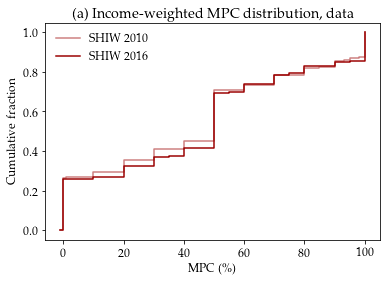

In [7]:
set_texfig()
plt.step(stats2010['MPC'], stats2010['cdf_weight'], where='post', color='#9A0000', alpha = 0.5, label='SHIW 2010')
plt.step(stats2016['MPC'], stats2016['cdf_weight'], where='post', color='#9A0000', label='SHIW 2016')
plt.xlabel('MPC (\%)')
plt.ylabel('Cumulative fraction')
plt.legend(framealpha=0)
plt.title('(a) Income-weighted MPC distribution, data')
plt.savefig('figures/figC1_a.pdf', format='pdf', transparent=True)

# Figure 1 asset response lower bound

In [8]:
r = calibration.r  # 0.05
T = 6

y_weight = (s2016['y'] * s2016['pesofit']).values / (s2016['y'] * s2016['pesofit']).sum()
mps = 1 - s2016['riscons2'].values/100

Implement equation (A.48), which gives an upper bound on asset holdings in response to a date-0 income shock, in terms of the income-weighted MPS distribution:

In [9]:
dAubar = np.array([(1+r)**t * y_weight @ mps**(t+1) for t in range(T)])

By corollary 2, if we calculate $\underline{dC_0} \equiv 1-\overline{dA_0}$ and $\underline{dC_t} \equiv (1+r)\overline{dA_{t-1}} - \overline{dA_t}$, then the cumulative PDV of $\underline{dC_t}$ is a lower bound for the cumulative consumption response up to any point.

Calculating, we get:

In [10]:
dClbar = - dAubar
dClbar[0] += 1
dClbar[1:] += (1+r)*dAubar[:-1]

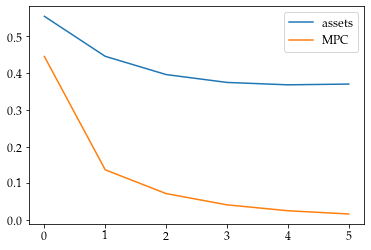

In [11]:
plt.plot(np.arange(T), dAubar, label='assets')
plt.plot(np.arange(T), dClbar, label='MPC')
plt.legend();

Save for use in our section 3 plot:

In [12]:
np.savetxt('impc_lb_italy.txt', dClbar)

# Figure C.1(b): Verify FOSD property required for bound to be valid 

We need to verify that for all $t$,  
    
$$ \mathbb{P}_{I}\left(\frac{z_{i}}{\mathbb{E}_{I}\left[z_{i}\right]}MPS_{0i}>m\right)>\mathbb{P}_{I}\left(\frac{z_{i}}{\mathbb{E}_{I}\left[z_{i}\right]}MPS_{ti}>m\right) $$

We will check this in our HA-one calibration. First, we obtain the steady state:

In [13]:
import json
with open('solved_params.json', 'r') as f:
    params = json.load(f)

calib_ha_one, _ = calibration.get_ha_calibrations()
ha_one = models_heterogeneous.ha_one
ss = ha_one.steady_state({**calib_ha_one, **params['HA-one']})

Next, we calculate MPCs at each idiosyncratic state:

In [14]:
internals = ss.internals['hh']
a, c, a_grid, r = internals['a'], internals['c'], internals['a_grid'], ss['r']
mpcs = np.empty_like(c)

# symmetric differences away from boundaries
mpcs[:, 1:-1] = (c[:, 2:] - c[:, 0:-2]) / (a_grid[2:] - a_grid[:-2]) / (1+r)

# asymmetric first differences at boundaries
mpcs[:, 0]  = (c[:, 1] - c[:, 0]) / (a_grid[1] - a_grid[0]) / (1+r)
mpcs[:, -1] = (c[:, -1] - c[:, -2]) / (a_grid[-1] - a_grid[-2]) / (1+r)

# special case of constrained
mpcs[a == a_grid[0]] = 1

Now, let's evaluate how the distribution moves over time, starting from the income-weighted distribution:

In [15]:
D, e = internals['D'], internals['e_grid']
De = D*e[:, np.newaxis]
assert np.isclose(De.sum(), 1)

Will use some undocumented parts of `het_block.py` to get a `law_of_motion` object that gives the action of `hh` on the distribution.

In [16]:
from sequence_jacobian.blocks.support.het_support import CombinedTransition
ss_hh = ha_one.extract_ss_dict(ss)
law_of_motion = CombinedTransition([ha_one.make_endog_law_of_motion(ss_hh), ha_one.make_exog_law_of_motion(ss_hh)])
assert np.allclose(law_of_motion.forward(D), D)

Display distribution of MPCs starting with `De`:

In [17]:
def plot_cdf(x, D, x0=0, *args, **kwargs):
    D = D.ravel()
    x = x.ravel()
    i = np.argsort(x)
    x = np.concatenate(([x0], x[i]))
    D = np.concatenate(([0], D[i].cumsum()))
    plt.plot(x, D, *args, **kwargs)

Plot Figure C1(b):

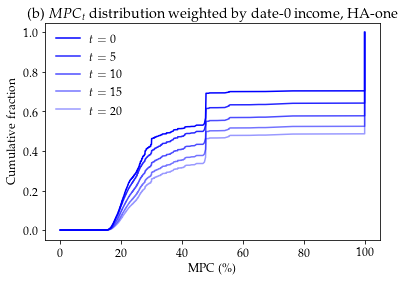

In [18]:
alphas = [1,0.85,0.7,0.55,0.4]
De_cur = De
for i in range(21):
    if i % 5 == 0:
        plot_cdf(100*mpcs, De_cur, label=f'$t={i}$', color = 'blue', alpha=alphas[i//5])
    De_cur = law_of_motion.forward(De_cur)
plt.xlabel('MPC (\%)')
plt.ylabel('Cumulative fraction')
plt.legend(framealpha=0)
plt.title(r'(b) $MPC_t$ distribution weighted by date-0 income, HA-one')
plt.savefig('figures/figC1_b.pdf', format='pdf', transparent=True)